In [1]:
# Install imblearn into conda 
!pip install imblearn

In [2]:
# Import libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm, preprocessing, metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score 
import winsound

In [3]:
# Function import data
def import_data(path=r'C:\Users\Home\OneDrive\Advent\insurance_claims_this_one.csv'):
    """pass path to CSV file location"""
    # Import data  
    df = pd.read_csv(path)
    return df                    

In [4]:
# Import data 
df = import_data()
# Show df to ensure data has been imported correctly 
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17/10/2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27/06/2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06/09/2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25/05/1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06/06/2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16/07/1991,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,05/01/2014,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,17/02/2003,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,18/11/2011,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [ ]:
# Grab col names 
col_names = df.columns

In [ ]:
# It is evident that some features have missing values marked ?, count these:
df.isin(['?']).sum(axis=0)

# EDA 

In [ ]:
# Import data for EDA 
df_eda = import_data()

In [ ]:
# Drop unwanted varibales for visualisation 
df_eda = df_eda.drop(['_c39', 'policy_bind_date', 'incident_date', 'incident_location'], axis=1)

In [ ]:
# Show histograms of numerical variables
df_eda.hist(bins=15, figsize=(18,8), layout=(3,6))

In [ ]:
# Display all categorical features using bar plots 
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

categorical=[]
for column in df_eda:
    if is_string_dtype(df_eda[column]):
        categorical.append(column)


fig, ax = plt.subplots(6, 2, figsize=(18, 32))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_eda[variable], ax=subplot, palette='bright')
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
fig.tight_layout()

In [ ]:
# Create heat map to visulaise correlation between features (Before pre-processing)
sns.set(rc = {'figure.figsize':(15,8)})
heat_map = sns.heatmap(df_eda.corr())
heat_map

In [ ]:
# Create histograms of numeric features with cases of fraud/no fraud highlighted 

# numeric col names 
column_name=[]
for i in range(df_eda.shape[1]):
    if df_eda.dtypes[i] == 'int64' or df_eda.dtypes[i] == 'float64':
        column_name.append(df_eda.columns[i])

# create df using numeric cols 
df_hist = df_eda.loc[:, [c for c in df_eda if c in column_name]]
# add target variable to df 
df_hist['fraud_reported'] = df_eda['fraud_reported']
# drop target and convert to array
data_array = np.array(df_hist)[:,0:-1]

#create df's with all rows of fraud/no fraud, then convert to arrays 
fig, axes = plt.subplots(6,3, figsize=(10,20))
no_fraud1 = df_hist.loc[df_hist['fraud_reported'] == 'N']
no_fraud = np.array(no_fraud1)[:,0:-1]
fraud1 = df_hist.loc[df_hist['fraud_reported'] == 'Y']
fraud = np.array(fraud1)[:,0:-1]

ax = axes.ravel()

for i in range(df_hist.shape[1]-1):
    _, bins = np.histogram(data_array[:, i], bins=50)
    ax[i].hist(no_fraud[:, i], bins=bins, color='cornflowerblue', alpha=.5)
    ax[i].hist(fraud[:, i], bins=bins, color='red', alpha=.5)
    ax[i].set_title(column_name[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Scale")
    ax[i].set_ylabel("frequency")
    ax[i].legend(["no_fraud", "fraud"], loc="best")
fig.tight_layout()

In [ ]:
# Create bar plots using seaborn catplot highlighting fraud Y/N differences 

df_fraud = df_eda[df_eda['fraud_reported'] == 'Y']
df_no_fraud = df_eda[df_eda['fraud_reported'] == 'N']

for variable in categorical:
    plot = sns.catplot(x=variable, col="fraud_reported", data=df_eda, kind='count',height=6, aspect=1.3, palette = 'bright')
    plot.set_xticklabels(rotation=90)
fig.tight_layout()

In [ ]:
# Examine target varible 
plt.figure(figsize=(6,6))
sns.countplot(x = 'fraud_reported', data = df, palette = 'bright')

## Clean Data and Preprocessing 

In [ ]:
# Function to clean data and preprocess 

def preprocess(df):
    """Takes df and cleans and preprocesses"""

    # Deal with ?'s in df
    df = df.replace('?', 'UNKNOWN')
    # Drop cols wiht no information gain
    df = df.drop(['policy_number','insured_zip','incident_location', '_c39'], axis=1)
    # Convert 'policy_bind_date', 'incident_date' from string to date_time object 
    cols = ['policy_bind_date', 'incident_date']
    df[cols] = df[cols].apply(pd.to_datetime)
    # Total days from policy taken out (creation date) to DOL (date of loss) 
    df['Total days from policy taken to DOL'] = (df['incident_date']-df['policy_bind_date']).dt.days
    # Drop the date_time obejects 
    df = df.drop(['policy_bind_date', 'incident_date'], axis=1)
    
    # Set labelencoder
    encode = preprocessing.LabelEncoder()
    # Labelencode suitable cols 
    df[['policy_state', 'policy_csl', 'umbrella_limit', 'insured_sex', 'insured_education_level', 'insured_occupation', 
        'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity',
        'authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 
        'police_report_available', 'auto_make', 'auto_model', 'fraud_reported']] = df[['policy_state', 'policy_csl', 
        'umbrella_limit', 'insured_sex', 'insured_education_level', 'insured_occupation', 
        'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity',
        'authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 
        'police_report_available', 'auto_make', 'auto_model', 'fraud_reported']].apply(encode.fit_transform)
    
    return df 

In [ ]:
# Change cell settings to display all rows 
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# pd.reset_option("display.max_rows")


### Get Dummies 

In [ ]:
# Function to get_dummies 

# def function for get dummies all
def get_dummies_all(df):
    """Function to create dummy variable for cols, pass df """
    # Create cols list for get_dummies func
    cols = ['policy_state', 'policy_csl', 'policy_deductable', 'insured_education_level', 'insured_relationship',
            'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city',
            'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 
            'auto_make', 'auto_year', 'insured_occupation', 'insured_hobbies', 'binned_months_as_customer', 'binned_age',
            'binned_policy_annual_premium', 'binned_capital_gains', 'binned_capital_loss', 'binned_incident_hour_of_the_day',
            'binned_total_claim_amount', 'binned_Total_days_from_policy_taken_to_DOL', 'binned_injury_claim',
            'binned_property_claim', 'binned_vehicle_claim', 'umbrella_limit', 'auto_model']
    df = pd.get_dummies(data=df, columns=cols)
    return df 

# def function for get dummies unbinned 
def get_dummies_unbinned(df):
    """Function to create dummy variable for cols, pass df """
    # Create cols list for get_dummies func
    cols = ['policy_state', 'policy_csl', 'policy_deductable', 'insured_education_level', 'insured_relationship',
            'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city',
            'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 
            'auto_make', 'auto_year', 'insured_occupation', 'insured_hobbies']
    df = pd.get_dummies(data=df, columns=cols)
    return df 

# def function for get dummies binned
def get_dummies_binned(df):
    """Function to create dummy variable for cols, pass df """
    # Create cols list for get_dummies func
    cols = ['binned_months_as_customer', 'binned_age',
            'binned_policy_annual_premium', 'binned_capital_gains', 'binned_capital_loss', 'binned_incident_hour_of_the_day',
            'binned_total_claim_amount', 'binned_Total_days_from_policy_taken_to_DOL', 'binned_injury_claim',
            'binned_property_claim', 'binned_vehicle_claim', 'umbrella_limit', 'auto_model']
    df = pd.get_dummies(data=df, columns=cols)
    return df 

### Bin Values

In [ ]:
# Function for binning choose values 

def bin_values(df):
    """input df and relevant cols will be binned and original cols dropped"""

    bin_labels_months_as_cust = [0,1,2,3,4,5,6,7,8]
    df['binned_months_as_customer'] = pd.cut(df['months_as_customer'],
                                             bins=[-1,0,2,6,12,18,24,100,300,500],
                                             labels=bin_labels_months_as_cust).astype(int)

    bin_labels_age = [0,1,2,3,4,5,6,7,8,9,10]
    df['binned_age'] = pd.cut(df['age'],
                             bins=[16,18,21,25,29,35,40,50,60,70,80,100],
                             labels=bin_labels_age).astype(int)

    bin_labels_policy_annual_premium = [0,1,2,3,4,5,6]
    df['binned_policy_annual_premium'] = pd.cut(df['policy_annual_premium'],
                                               bins=[1,500,1000,1500,2000,2500,3000,4000],
                                               labels=bin_labels_policy_annual_premium).astype(int)
    bin_labels_capital_gains = [0,1,2,3,4,5,6]
    df['binned_capital_gains'] = pd.cut(df['capital-gains'],
                                       bins=[-1,0,20000,40000,60000,80000,100000,150000],
                                       labels=bin_labels_capital_gains).astype(int)

    bin_labels_capital_loss = [0,1,2,3,4,5,6]
    df['binned_capital_loss'] = pd.cut(df['capital-loss'],
                                       bins=[-150000,-100000,-80000,-60000,-40000,-20000,0,1],
                                       labels=bin_labels_capital_loss).astype(int)

    bin_labels_incident_hour_of_the_day = [0,1,2,3]
    df['binned_incident_hour_of_the_day'] = pd.cut(df['incident_hour_of_the_day'],
                                                   bins=[-1,0,6,12,24],
                                                   labels=bin_labels_incident_hour_of_the_day).astype(int)

    bin_labels_total_claim_amount = [0,1,2,3,4,5,6,7,8,9]
    df['binned_total_claim_amount'] = pd.cut(df['total_claim_amount'],
                                            bins=[1,250,500,1000,2000,5000,10000,20000,50000,100000,150000],
                                            labels=bin_labels_total_claim_amount).astype(int)

    bin_labels_Total_days_from_policy_taken_to_DOL = [0,1,2,3,4,5,6,7,8,9,10,11]
    df['binned_Total_days_from_policy_taken_to_DOL'] = pd.cut(df['Total days from policy taken to DOL'],
                                                             bins=[-100,-80,0,5,10,30,100,250,500,1000,2500,5000,10000],
                                                             labels=bin_labels_Total_days_from_policy_taken_to_DOL).astype(int)
    
    bin_labels_injury_claim = [0,1,2,3,4,5,6]
    df['binned_injury_claim'] = pd.cut(df['injury_claim'],
                                      bins=[-1,0,5000,10000,15000,20000,25000,50000],
                                      labels=bin_labels_injury_claim).astype(int)
    
    bin_labels_property_claim = [0,1,2,3,4,5,6]
    df['binned_property_claim'] = pd.cut(df['property_claim'],
                                      bins=[-1,0,5000,10000,15000,20000,25000,50000],
                                      labels=bin_labels_injury_claim).astype(int)
    
    bin_labels_vehicle_claim = [0,1,2,3,4,5,6,7,8]
    df['binned_vehicle_claim'] = pd.cut(df['vehicle_claim'],
                                      bins=[-1,0,5000,10000,15000,20000,25000,50000,75000,100000],
                                      labels=bin_labels_vehicle_claim).astype(int)
    
    df = df.drop(['months_as_customer', 'policy_annual_premium', 'age', 'policy_annual_premium', 'capital-gains',
                 'capital-loss', 'incident_hour_of_the_day', 'total_claim_amount', 'Total days from policy taken to DOL',
                 'injury_claim', 'property_claim', 'vehicle_claim'],
                axis=1)
    
    return df 


### Apply Preprocessing Pipes

In [ ]:
# Using pipes to call functions and create 3 df's with varying amount of binned values 
df_v = import_data().pipe(preprocess)
df = import_data().pipe(preprocess).pipe(bin_values)
df_all = import_data().pipe(preprocess).pipe(bin_values).pipe(get_dummies_all)
df_binned = import_data().pipe(preprocess).pipe(bin_values).pipe(get_dummies_binned)
df_unbinned = import_data().pipe(preprocess).pipe(bin_values).pipe(get_dummies_unbinned)

In [ ]:
# Create heat map of features to display correlation (after preprocessing)
sns.set(rc = {'figure.figsize':(15,8)})
heat_map = sns.heatmap(df_v.corr())
heat_map

# Apply ML models 

In [ ]:
# Function to create x and y, then x_test, y_test

def train_test(df):
    """Takes df and returns x, y, x_train, y_train, x_test, y_test"""
    
    # Split into x and y 
    x = df.loc[:, df.columns != 'fraud_reported']
    y = pd.DataFrame(df['fraud_reported'])

    # split the data into train and test set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    
    return x, y, x_train, x_test, y_train, y_test

### Set train/test sets 

In [ ]:
x, y, x_train, x_test, y_train, y_test = train_test(df)

### SMOTE 

In [ ]:
#Over sample the minority class using SMOTE

sm = SMOTE(random_state=42)

x_sm, y_sm = sm.fit_resample(x_train, y_train)

print(f'''Shape of x before SMOTE: {x_train.shape}
      Shape of x after SMOTE: {x_sm.shape}''')

In [ ]:
# Visualise target variable Churn 
y_smote = pd.DataFrame(y_sm, columns = ['fraud_reported'])
# Traget Varibale is now balanced
plt.figure(figsize=(6,6))
sns.countplot(x = 'fraud_reported', data = y_smote, palette='bright')
# Percemtage of churn = 
fraud = y_sm == 1
y_true = y_sm[fraud]
print("percent of fraud/no fraud (%):" +str((y_true.shape[0] / y_sm.shape[0] * 100)))
# Class is now balanced 

# Evaluate performance on data with preprocessing and binned features (no label encoding)

In [ ]:
x, y, x_train, x_test, y_train, y_test = train_test(df)

# DT

In [ ]:
# Function to perform nested CV on DT model 
def DT_nested(x_train, y_train):
    """pass x_train, y_train and function will perfrom nested CV on DT model to indicate how model may generalise"""
    
    clf = DecisionTreeClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    scores = cross_val_score(grid, x_train, y_train, cv=5)
    print('Average cross_val score of DT: %.4f' % scores.mean())

In [ ]:
def DT_grid(x_train, x_test, y_train, y_test):
    """pass x_train, X_test, y_train, y_test and function will perfrom gridsearch CV and return scores and print best params"""
    
    clf = DecisionTreeClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train.values.ravel())
    
    # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score for the DT model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the DT model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [ ]:
# Function to provide confusion matrix on saved back test data 
def DT_eval(x_train, x_test, y_train, y_test, criterion='entropy', max_depth=4, class_weight='balanced'):
    """Create confusion matrix. Pass best params manually from printed DT_grid function result"""
    clf=DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, class_weight=class_weight)
    clf.fit(x_train, y_train.values.ravel())
    DT_preds = clf.predict(x_test)
    DT_acc = clf.score(x_test, y_test.values.ravel())
    DT_cm = confusion_matrix(y_test, DT_preds)
    DT_precision, DT_recall, DT_f1score, _ = precision_recall_fscore_support(y_test, DT_preds, average='binary')
    DT_auc = roc_auc_score(y_test, DT_preds)
    return DT_acc, DT_cm, DT_precision, DT_recall, DT_f1score, DT_auc, DT_preds

In [ ]:
# Perfomed nested CV on DT model 
DT_nested(x_train, y_train)

In [ ]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_train, x_test, y_train, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
DT_acc, DT_cm, DT_precision, DT_recall, DT_f1score, DT_auc, DT_preds = DT_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=4, 
                                                                               class_weight='balanced')
print("Accuracy:\t", "%0.4f" % DT_acc)
print("Precision:\t", "%0.4f" % DT_precision)
print("Recall:\t\t", "%0.4f" % DT_recall)
print("F1 Score:\t", "%0.4f" % DT_f1score)
print("AUC:\t\t", "%0.4f" % DT_auc)
DT_cm

In [ ]:
con = confusion_matrix(y_test, DT_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forrest Classifier 

In [ ]:
# Function to perform nested CV on RF model 
def RF_nested(x_train, y_train):
    """pass x_train, y_train and function will perfrom nested CV on RF model to indicate how model may generalise"""
    
    clf = RandomForestClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    scores = cross_val_score(grid, x_train, y_train, cv=5)
    print('Average cross_val score of RF: %.4f' % scores.mean())

In [ ]:
def RF_grid(x_train, x_test, y_train, y_test):
    """pass x_train, X_test, y_train, y_test and function will perfrom gridsearch CV and return scores and print best params"""
    
    clf = RandomForestClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train.values.ravel())
    
    # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score for the RF model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the RF model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [ ]:
# Function to provide confusion matrix on saved back test data 
def RF_eval(x_train, x_test, y_train, y_test, criterion='gini', max_depth=6, class_weight={0: 1, 1: 5}):
    """Create confusion matrix. Pass best params manually from printed DT_grid function result"""
    clf=RandomForestClassifier(criterion=criterion, max_depth=max_depth, class_weight=class_weight)
    clf.fit(x_train, y_train.values.ravel())
    RF_preds = clf.predict(x_test)
    cm = confusion_matrix(y_test, RF_preds)
    RF_acc = clf.score(x_test, y_test.values.ravel())
    RF_cm = confusion_matrix(y_test, RF_preds)
    RF_precision, RF_recall, RF_f1score, _ = precision_recall_fscore_support(y_test, RF_preds, average='binary')
    RF_auc = roc_auc_score(y_test, RF_preds)
    return RF_acc, RF_cm, RF_precision, RF_recall, RF_f1score, RF_auc, RF_preds    

In [ ]:
# Perfomed nested CV on DT model 
RF_nested(x_train, y_train)

In [ ]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_train, x_test, y_train, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RF_acc, RF_cm, RF_precision, RF_recall, RF_f1score, RF_auc, RF_preds = RF_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='gini', max_depth=6, 
                                                                               class_weight={0: 1, 1: 5})
print("RF Accuracy:\t", "%0.4f" % RF_acc)
print("RF Precision:\t", "%0.4f" % RF_precision)
print("RF Recall:\t", "%0.4f" % RF_recall)
print("RF F1 Score:\t", "%0.4f" % RF_f1score)
print("RF AUC:\t\t", "%0.4f" % RF_auc)
RF_cm

In [ ]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RF_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SVM

In [ ]:
# Function to perform nested CV with grid search on SVM to examine how the model will potentially generalise 

def SVM_nested(x_train, y_train):
    """Pass x,y and function performs nested CV with gridsearch with SVM"""
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    clf = svm.SVC() # define model
    param_grid = {'C': [0.1,1,10,100],
                  'gamma': [1,0.1,0.01,0.001],
                  'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='f1') 
    scores = cross_val_score(grid, x_train, y_train.values.ravel(), cv=5, scoring='f1') 
    # report performance
    return print('Average cross_val score of SVM: %.4f' % scores.mean())

In [ ]:
# Function which performs gridsearch and returns scores and best params 

def SVM_grid(x_train, x_test, y_train, y_test):
    """Pass x_train, x_test, y_train, y_test"""
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    clf = svm.SVC() # define model
    param_grid = {'C': [0.1,1,10,100, 500],
                  'gamma': [1,0.1,0.01,0.001],
                  'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='f1') 
    grid.fit(x_train, y_train.values.ravel()) # fit 
    
    # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score for the SVM model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the SVM model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [ ]:
# Function to evaluate cm of SVM on test data 
def SVM_eval(x_train, x_test, y_train, y_test, C = 0.1, class_weight= {0: 100, 1: 1}, gamma= 1):
    """pass x_train, x_test, y_train, y_test and best params manually from printed grid result"""
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    clf = svm.SVC(C=C, gamma=gamma, class_weight = class_weight)
    clf.fit(x_train, y_train.values.ravel())
    SVM_preds = clf.predict(x_test)
    cm = confusion_matrix(y_test, SVM_preds)
    SVM_acc = clf.score(x_test, y_test.values.ravel())
    SVM_cm = confusion_matrix(y_test, SVM_preds)
    SVM_precision, SVM_recall, SVM_f1score, _ = precision_recall_fscore_support(y_test, SVM_preds, average='binary')
    SVM_auc = roc_auc_score(y_test, SVM_preds)
    return SVM_acc, SVM_cm, SVM_precision, SVM_recall, SVM_f1score, SVM_auc, SVM_preds    

In [ ]:
# Perfomed nested CV on SVM model 
SVM_nested(x_train, y_train)

In [ ]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_train, x_test, y_train, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVM_acc, SVM_cm, SVM_precision, SVM_recall, SVM_f1score, SVM_auc, SVM_preds = SVM_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               C = 100, class_weight= {0: 1, 1: 1}, 
                                                                                       gamma= 0.001)
print("SVM Accuracy:\t", "%0.4f" % SVM_acc)
print("SVM Precision:\t", "%0.4f" % SVM_precision)
print("SVM Recall:\t", "%0.4f" % SVM_recall)
print("SVM F1 Score:\t", "%0.4f" % SVM_f1score)
print("SVM AUC:\t", "%0.4f" % SVM_auc)
SVM_cm

In [ ]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVM_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# XGBoost 

In [ ]:
# Function to perform nested grid search on XGB

def XGB_nested(x_train, y_train):
    """Takes x_train, y_train and performs nested grid search and return best score, indicates how model will generalise 
    to unseen data"""

    # Nested CV to indicate how well model will generalise to unseen data 
    clf = XGBClassifier(validate_parameters=True, eval_metric='auc', silent=True, verbosity=0)
    param_grid = {'learning_rate': [0.00001,0.0001,0.001,0.01,0.1,0.5,1], 
                  'max_depth': [2,3,5,10,15,20,30,50],
                 "scale_pos_weight": [1, 3, 5, 10]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1) 
    scores = cross_val_score(grid, x_train, y_train.values.ravel(), cv=5, scoring='accuracy') 
    
    # report performance
    return print('Average cross_val score of SVM: %.4f' % scores.mean())

In [ ]:
# Function for XGB evaluation 

def XGB_grid(x_train, x_test, y_train, y_test):
    """Takes x and y and performs grid search, returns CV score, best paras from grid search, score on test set,
    and confusion matrix"""
    
    clf = XGBClassifier(validate_parameters=True, eval_metric='auc', silent=True, verbosity=0)
    
    # Hyper-tuner parameters and print results 
    param_grid = {'learning_rate': [0.0001,0.0001,0.001,0.01,0.1,0.5,1], 
                  'max_depth': [2,3,5,10,15,20,30,50],
                 "scale_pos_weight": [1, 3, 5, 10]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train.values.ravel()) # fit 
    
    # # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score with parameter tuning for the XGB model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the XGB model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [ ]:
# Function to evaluate SVM on test data 

def XGB_eval(x_train, x_test, y_train, y_test, learning_rate=0.001, max_depth=3, scale_pos_weight = 3):
    
    """pass x_train, x_test, y_train, y_test and best params manually from printed grid result"""
    clf = XGBClassifier(validate_parameters=True, eval_metric='auc',
                        learning_rate=learning_rate, max_depth=max_depth, scale_pos_weight = scale_pos_weight, silent=True, verbosity=0)
    clf.fit(x_train, y_train.values.ravel())
    XGB_preds = clf.predict(x_test)
    cm = confusion_matrix(y_test, XGB_preds)
    XGB_acc = clf.score(x_test, y_test.values.ravel())
    XGB_cm = confusion_matrix(y_test, XGB_preds)
    XGB_precision, XGB_recall, XGB_f1score, _ = precision_recall_fscore_support(y_test, XGB_preds, average='binary')
    XGB_auc = roc_auc_score(y_test, XGB_preds)
    return XGB_acc, XGB_cm, XGB_precision, XGB_recall, XGB_f1score, XGB_auc, XGB_preds  

In [ ]:
# Perform nested CV on XGB model 
XGB_nested(x_train, y_train)
winsound.MessageBeep()

In [ ]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGB_acc, XGB_cm, XGB_precision, XGB_recall, XGB_f1score, XGB_auc, XGB_preds = XGB_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               learning_rate = 0.01, 
                                                                               max_depth = 2,
                                                                               scale_pos_weight = 5)
print("XGB Accuracy:\t", "%0.4f" % XGB_acc)
print("XGB Precision:\t", "%0.4f" % XGB_precision)
print("XGB Recall:\t", "%0.4f" % XGB_recall)
print("XGB F1 Score:\t", "%0.4f" % XGB_f1score)
print("XGB AUC:\t", "%0.4f" % XGB_auc)
XGB_cm
winsound.MessageBeep()

In [ ]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGB_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Create table of accuracies for data with preprocessing AND binned values  
performance_preprossed_only = pd.DataFrame({
    'Model' : ['Descision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy' : [round(DT_acc, 4), round(RF_acc, 4), round(SVM_acc, 4), round(XGB_acc, 4)],
    'Precision' : [round(DT_precision, 4), round(RF_precision, 4), round(SVM_precision, 4), round(XGB_precision, 4)],
    'Recall' : [round(DT_recall, 4), round(RF_recall, 4), round(SVM_recall, 4), round(XGB_recall, 4)],
    'F1 Score' : [round(DT_f1score, 4), round(RF_f1score, 4), round(SVM_f1score, 4), round(XGB_f1score, 4)],
    'AUC' : [round(DT_auc, 4), round(RF_auc, 4), round(SVM_auc, 4), round(XGB_auc, 4)]
})
performance_preprossed_only_df = performance_preprossed_only.sort_values(by='Recall', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(performance_preprossed_only_df)
fig.update_layout(
    autosize=False,
    width=700,
    height=200,
)
fig.show()

# Model performance with JUST preprocessing applied 

### DT 

In [373]:
x, y, x_train, x_test, y_train, y_test = train_test(df_v)

In [ ]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
DT1_acc, DT1_cm, DT1_precision, DT1_recall, DT1_f1score, DT1_auc, DT1_preds = DT_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=4, 
                                                                               class_weight='balanced')
print("Accuracy:\t", "%0.4f" % DT1_acc)
print("Precision:\t", "%0.4f" % DT1_precision)
print("Recall:\t\t", "%0.4f" % DT1_recall)
print("F1 Score:\t", "%0.4f" % DT1_f1score)
print("AUC:\t\t", "%0.4f" % DT1_auc)
DT1_cm
winsound.MessageBeep()

In [ ]:
con = confusion_matrix(y_test, DT1_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### RF 

In [ ]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RF1_acc, RF1_cm, RF1_precision, RF1_recall, RF1_f1score, RF1_auc, RF1_preds = RF_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='gini', max_depth=4, 
                                                                               class_weight='balanced')
print("RF Accuracy:\t", "%0.4f" % RF1_acc)
print("RF Precision:\t", "%0.4f" % RF1_precision)
print("RF Recall:\t", "%0.4f" % RF1_recall)
print("RF F1 Score:\t", "%0.4f" % RF1_f1score)
print("RF AUC:\t\t", "%0.4f" % RF1_auc)
RF1_cm

In [ ]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RF1_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM 

In [ ]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVM1_acc, SVM1_cm, SVM1_precision, SVM1_recall, SVM1_f1score, SVM1_auc, SVM1_preds = SVM_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               C = 100, class_weight= {0: 1, 1: 1}, 
                                                                                       gamma= 0.001)
print("SVM Accuracy:\t", "%0.4f" % SVM1_acc)
print("SVM Precision:\t", "%0.4f" % SVM1_precision)
print("SVM Recall:\t", "%0.4f" % SVM1_recall)
print("SVM F1 Score:\t", "%0.4f" % SVM1_f1score)
print("SVM AUC:\t", "%0.4f" % SVM1_auc)
SVM1_cm

In [ ]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVM1_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGB

In [ ]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGB1_acc, XGB1_cm, XGB1_precision, XGB1_recall, XGB1_f1score, XGB1_auc, XGB1_preds = XGB_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               learning_rate = 0.01, 
                                                                               max_depth = 2,
                                                                               scale_pos_weight = 5)
print("XGB Accuracy:\t", "%0.4f" % XGB1_acc)
print("XGB Precision:\t", "%0.4f" % XGB1_precision)
print("XGB Recall:\t", "%0.4f" % XGB1_recall)
print("XGB F1 Score:\t", "%0.4f" % XGB1_f1score)
print("XGB AUC:\t", "%0.4f" % XGB1_auc)
XGB1_cm
winsound.MessageBeep()

In [ ]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGB1_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Create table of accuracies for data with PREPROCESSING AND BINNED VALUES
performance_preprossed_only = pd.DataFrame({
    'Model' : ['Descision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy' : [round(DT1_acc, 4), round(RF1_acc, 4), round(SVM1_acc, 4), round(XGB1_acc, 4)],
    'Precision' : [round(DT1_precision, 4), round(RF1_precision, 4), round(SVM1_precision, 4), round(XGB1_precision, 4)],
    'Recall' : [round(DT1_recall, 4), round(RF1_recall, 4), round(SVM1_recall, 4), round(XGB1_recall, 4)],
    'F1 Score' : [round(DT1_f1score, 4), round(RF1_f1score, 4), round(SVM1_f1score, 4), round(XGB1_f1score, 4)],
    'AUC' : [round(DT1_auc, 4), round(RF1_auc, 4), round(SVM1_auc, 4), round(XGB1_auc, 4)]
})
performance_preprossed_only_df = performance_preprossed_only.sort_values(by='Recall', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(performance_preprossed_only_df)
fig.update_layout(
    autosize=False,
    width=700,
    height=200,
)
fig.show()

# Performance with preprocessing, binned values and ALL dummy variables 

In [ ]:
x, y, x_train, x_test, y_train, y_test = train_test(df_all)

### DT

In [ ]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
DT2_acc, DT2_cm, DT2_precision, DT2_recall, DT2_f1score, DT2_auc, DT2_preds = DT_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=4, 
                                                                               class_weight={0: 1, 1: 5})
print("Accuracy:\t", "%0.4f" % DT2_acc)
print("Precision:\t", "%0.4f" % DT2_precision)
print("Recall:\t\t", "%0.4f" % DT2_recall)
print("F1 Score:\t", "%0.4f" % DT2_f1score)
print("AUC:\t\t", "%0.4f" % DT2_auc)
DT2_cm

In [ ]:
con = confusion_matrix(y_test, DT2_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### RF

In [ ]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RF2_acc, RF2_cm, RF2_precision, RF2_recall, RF2_f1score, RF2_auc, RF2_preds = RF_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='gini', max_depth=2, 
                                                                               class_weight='balanced')
print("RF Accuracy:\t", "%0.4f" % RF2_acc)
print("RF Precision:\t", "%0.4f" % RF2_precision)
print("RF Recall:\t", "%0.4f" % RF2_recall)
print("RF F1 Score:\t", "%0.4f" % RF2_f1score)
print("RF AUC:\t\t", "%0.4f" % RF2_auc)
RF2_cm

In [ ]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RF2_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [ ]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVM2_acc, SVM2_cm, SVM2_precision, SVM2_recall, SVM2_f1score, SVM2_auc, SVM2_preds = SVM_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               C = 10, class_weight= {0: 1, 1: 10}, 
                                                                               gamma= 0.001)
print("SVM Accuracy:\t", "%0.4f" % SVM2_acc)
print("SVM Precision:\t", "%0.4f" % SVM2_precision)
print("SVM Recall:\t", "%0.4f" % SVM2_recall)
print("SVM F1 Score:\t", "%0.4f" % SVM2_f1score)
print("SVM AUC:\t", "%0.4f" % SVM2_auc)
SVM2_cm

In [ ]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVM2_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGB

In [ ]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGB2_acc, XGB2_cm, XGB2_precision, XGB2_recall, XGB2_f1score, XGB2_auc, XGB2_preds = XGB_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               learning_rate = 0.01, max_depth = 2,
                                                                                             scale_pos_weight=10)
print("XGB Accuracy:\t", "%0.4f" % XGB2_acc)
print("XGB Precision:\t", "%0.4f" % XGB2_precision)
print("XGB Recall:\t", "%0.4f" % XGB2_recall)
print("XGB F1 Score:\t", "%0.4f" % XGB2_f1score)
print("XGB AUC:\t", "%0.4f" % XGB2_auc)
XGB2_cm

In [ ]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGB2_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Create table of accuracies for data with PREPROCESSING AND BINNED VALUES
performance_preprossed_only = pd.DataFrame({
    'Model' : ['Descision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy' : [round(DT2_acc, 4), round(RF2_acc, 4), round(SVM2_acc, 4), round(XGB2_acc, 4)],
    'Precision' : [round(DT2_precision, 4), round(RF2_precision, 4), round(SVM2_precision, 4), round(XGB2_precision, 4)],
    'Recall' : [round(DT2_recall, 4), round(RF2_recall, 4), round(SVM2_recall, 4), round(XGB2_recall, 4)],
    'F1 Score' : [round(DT2_f1score, 4), round(RF2_f1score, 4), round(SVM2_f1score, 4), round(XGB2_f1score, 4)],
    'AUC' : [round(DT2_auc, 4), round(RF2_auc, 4), round(SVM2_auc, 4), round(XGB2_auc, 4)]
})
performance_preprossed_only_df = performance_preprossed_only.sort_values(by='Recall', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(performance_preprossed_only_df)
fig.update_layout(
    autosize=False,
    width=700,
    height=200,
)
fig.show()

# Performance on preprocessed data, with get dummies on all binned data 

### DT

In [ ]:
x, y, x_train, x_test, y_train, y_test = train_test(df_binned)

In [ ]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
DT3_acc, DT3_cm, DT3_precision, DT3_recall, DT3_f1score, DT3_auc, DT3_preds = DT_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=4, 
                                                                               class_weight={0: 1, 1: 5})
print("Accuracy:\t", "%0.4f" % DT3_acc)
print("Precision:\t", "%0.4f" % DT3_precision)
print("Recall:\t\t", "%0.4f" % DT3_recall)
print("F1 Score:\t", "%0.4f" % DT3_f1score)
print("AUC:\t\t", "%0.4f" % DT3_auc)
DT3_cm

In [ ]:
con = confusion_matrix(y_test, DT3_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### RF

In [ ]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RF3_acc, RF3_cm, RF3_precision, RF3_recall, RF3_f1score, RF3_auc, RF3_preds = RF_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=8, 
                                                                               class_weight={0: 1, 1: 5})
print("RF Accuracy:\t", "%0.4f" % RF3_acc)
print("RF Precision:\t", "%0.4f" % RF3_precision)
print("RF Recall:\t", "%0.4f" % RF3_recall)
print("RF F1 Score:\t", "%0.4f" % RF3_f1score)
print("RF AUC:\t\t", "%0.4f" % RF3_auc)
RF3_cm

In [ ]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RF3_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [ ]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVM3_acc, SVM3_cm, SVM3_precision, SVM3_recall, SVM3_f1score, SVM3_auc, SVM3_preds = SVM_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               C = 100, class_weight= {0: 1, 1: 10}, 
                                                                                       gamma= 0.001)
print("SVM Accuracy:\t", "%0.4f" % SVM3_acc)
print("SVM Precision:\t", "%0.4f" % SVM3_precision)
print("SVM Recall:\t", "%0.4f" % SVM3_recall)
print("SVM F1 Score:\t", "%0.4f" % SVM3_f1score)
print("SVM AUC:\t", "%0.4f" % SVM3_auc)
SVM3_cm

In [ ]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVM3_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGB 

In [ ]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGB3_acc, XGB3_cm, XGB3_precision, XGB3_recall, XGB3_f1score, XGB3_auc, XGB3_preds = XGB_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               learning_rate = 0.001, max_depth = 3,
                                                                                             scale_pos_weight=3)
print("XGB Accuracy:\t", "%0.4f" % XGB3_acc)
print("XGB Precision:\t", "%0.4f" % XGB3_precision)
print("XGB Recall:\t", "%0.4f" % XGB3_recall)
print("XGB F1 Score:\t", "%0.4f" % XGB3_f1score)
print("XGB AUC:\t", "%0.4f" % XGB3_auc)
XGB3_cm

In [ ]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGB3_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Create table of accuracies for data with PREPROCESSING AND BINNED VALUES
performance_preprossed_only = pd.DataFrame({
    'Model' : ['Descision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy' : [round(DT3_acc, 4), round(RF3_acc, 4), round(SVM3_acc, 4), round(XGB3_acc, 4)],
    'Precision' : [round(DT3_precision, 4), round(RF3_precision, 4), round(SVM3_precision, 4), round(XGB3_precision, 4)],
    'Recall' : [round(DT3_recall, 4), round(RF3_recall, 4), round(SVM3_recall, 4), round(XGB3_recall, 4)],
    'F1 Score' : [round(DT3_f1score, 4), round(RF3_f1score, 4), round(SVM3_f1score, 4), round(XGB3_f1score, 4)],
    'AUC' : [round(DT3_auc, 4), round(RF3_auc, 4), round(SVM3_auc, 4), round(XGB3_auc, 4)]
})
performance_preprossed_only_df = performance_preprossed_only.sort_values(by='Accuracy', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(performance_preprossed_only_df)
fig.update_layout(
    autosize=False,
    width=700,
    height=200,
)
fig.show()

# Performance on data with preprocessing and dummy variables on only the unbinned features 

### DT

In [ ]:
x, y, x_train, x_test, y_train, y_test = train_test(df_unbinned)

In [ ]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_train, x_test, y_train, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
DT4_acc, DT4_cm, DT4_precision, DT4_recall, DT4_f1score, DT4_auc, DT4_preds = DT_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='gini', max_depth=4, 
                                                                               class_weight={0: 1, 1: 5})
print("Accuracy:\t", "%0.4f" % DT4_acc)
print("Precision:\t", "%0.4f" % DT4_precision)
print("Recall:\t\t", "%0.4f" % DT4_recall)
print("F1 Score:\t", "%0.4f" % DT4_f1score)
print("AUC:\t\t", "%0.4f" % DT4_auc)
DT4_cm

In [ ]:
con = confusion_matrix(y_test, DT4_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### RF

In [ ]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RF4_acc, RF4_cm, RF4_precision, RF4_recall, RF4_f1score, RF4_auc, RF4_preds = RF_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='gini', max_depth=6, 
                                                                               class_weight={0: 1, 1: 5})
print("RF Accuracy:\t", "%0.4f" % RF4_acc)
print("RF Precision:\t", "%0.4f" % RF4_precision)
print("RF Recall:\t", "%0.4f" % RF4_recall)
print("RF F1 Score:\t", "%0.4f" % RF4_f1score)
print("RF AUC:\t\t", "%0.4f" % RF4_auc)
RF4_cm

In [ ]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RF4_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM 

In [ ]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVM4_acc, SVM4_cm, SVM4_precision, SVM4_recall, SVM4_f1score, SVM4_auc, SVM4_preds = SVM_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               C = 10, class_weight= {0: 1, 1: 10}, 
                                                                                       gamma= 0.001)
print("SVM Accuracy:\t", "%0.4f" % SVM4_acc)
print("SVM Precision:\t", "%0.4f" % SVM4_precision)
print("SVM Recall:\t", "%0.4f" % SVM4_recall)
print("SVM F1 Score:\t", "%0.4f" % SVM4_f1score)
print("SVM AUC:\t", "%0.4f" % SVM4_auc)
SVM4_cm

In [ ]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVM4_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGB

In [ ]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_train, x_test, y_train, y_test)
winsound.MessageBeep()

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGB4_acc, XGB4_cm, XGB4_precision, XGB4_recall, XGB4_f1score, XGB4_auc, XGB4_preds = XGB_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               learning_rate = 0.01, max_depth = 2,
                                                                                             scale_pos_weight=10)
print("XGB Accuracy:\t", "%0.4f" % XGB4_acc)
print("XGB Precision:\t", "%0.4f" % XGB4_precision)
print("XGB Recall:\t", "%0.4f" % XGB4_recall)
print("XGB F1 Score:\t", "%0.4f" % XGB4_f1score)
print("XGB AUC:\t", "%0.4f" % XGB4_auc)
XGB4_cm

In [ ]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGB4_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Create table of accuracies for data with PREPROCESSING AND BINNED VALUES
performance_preprossed_only = pd.DataFrame({
    'Model' : ['Descision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy' : [round(DT4_acc, 4), round(RF4_acc, 4), round(SVM4_acc, 4), round(XGB4_acc, 4)],
    'Precision' : [round(DT4_precision, 4), round(RF4_precision, 4), round(SVM4_precision, 4), round(XGB4_precision, 4)],
    'Recall' : [round(DT4_recall, 4), round(RF4_recall, 4), round(SVM4_recall, 4), round(XGB4_recall, 4)],
    'F1 Score' : [round(DT4_f1score, 4), round(RF4_f1score, 4), round(SVM4_f1score, 4), round(XGB4_f1score, 4)],
    'AUC' : [round(DT4_auc, 4), round(RF4_auc, 4), round(SVM4_auc, 4), round(XGB4_auc, 4)]
})
performance_preprossed_only_df = performance_preprossed_only.sort_values(by='Recall', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(performance_preprossed_only_df)
fig.update_layout(
    autosize=False,
    width=700,
    height=200,
)
fig.show()

# SMOTE applied to dataset with best performance so far 

## DT

In [366]:
x, y, x_train, x_test, y_train, y_test = train_test(df)

In [367]:
#Over sample the minority class using SMOTE

sm = SMOTE(random_state=42)

x_sm, y_sm = sm.fit_resample(x_train, y_train)

print(f'''Shape of x before SMOTE: {x_train.shape}
Shape of x after SMOTE: {x_sm.shape}''')

Shape of x before SMOTE: (800, 34)
Shape of x after SMOTE: (1216, 34)


In [368]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_sm, x_test, y_sm, y_test)

 The best cross validation score for the DT model is: 0.8504
 The best parameters for the DT model: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 4}
 Test score: 0.8150


In [ ]:
DTS_acc, DTS_cm, DTS_precision, DTS_recall, DTS_f1score, DTS_auc, DTS_preds = DT_eval(x_sm, 
                                                                               x_test, y_sm, y_test, 
                                                                               criterion='gini', max_depth=4, 
                                                                               class_weight={0: 1, 1: 1})
print("Accuracy:\t", "%0.4f" % DTS_acc)
print("Precision:\t", "%0.4f" % DTS_precision)
print("Recall:\t\t", "%0.4f" % DTS_recall)
print("F1 Score:\t", "%0.4f" % DTS_f1score)
print("AUC:\t\t", "%0.4f" % DTS_auc)
DTS_cm

In [ ]:
con = confusion_matrix(y_test, DTS_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('No Fraud', 'Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### RF

In [ ]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_sm, x_test, y_sm, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RFS_acc, RFS_cm, RFS_precision, RFS_recall, RFS_f1score, RFS_auc, RFS_preds = RF_eval(x_sm, 
                                                                               x_test, y_sm, y_test, 
                                                                               criterion='entropy', max_depth=10, 
                                                                               class_weight='balanced')
print("RF Accuracy:\t", "%0.4f" % RFS_acc)
print("RF Precision:\t", "%0.4f" % RFS_precision)
print("RF Recall:\t", "%0.4f" % RFS_recall)
print("RF F1 Score:\t", "%0.4f" % RFS_f1score)
print("RF AUC:\t\t", "%0.4f" % RFS_auc)
RFS_cm

In [ ]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RFS_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [ ]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_sm, x_test, y_sm, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVMS_acc, SVMS_cm, SVMS_precision, SVMS_recall, SVMS_f1score, SVMS_auc, SVMS_preds = SVM_eval(x_sm, 
                                                                               x_test, y_sm, y_test, 
                                                                               C = 10, class_weight= {0: 100, 1: 1}, 
                                                                                       gamma= 0.01)
print("SVM Accuracy:\t", "%0.4f" % SVMS_acc)
print("SVM Precision:\t", "%0.4f" % SVMS_precision)
print("SVM Recall:\t", "%0.4f" % SVMS_recall)
print("SVM F1 Score:\t", "%0.4f" % SVMS_f1score)
print("SVM AUC:\t", "%0.4f" % SVMS_auc)
SVMS_cm

In [ ]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVMS_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGBoost 

In [ ]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_sm, x_test, y_sm, y_test)

In [ ]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGBS_acc, XGBS_cm, XGBS_precision, XGBS_recall, XGBS_f1score, XGBS_auc, XGBS_preds = XGB_eval(x_sm, 
                                                                               x_test, y_sm, y_test, 
                                                                               learning_rate = 0.5, max_depth = 10,
                                                                                             scale_pos_weight=1)
print("XGB Accuracy:\t", "%0.4f" % XGBS_acc)
print("XGB Precision:\t", "%0.4f" % XGBS_precision)
print("XGB Recall:\t", "%0.4f" % XGBS_recall)
print("XGB F1 Score:\t", "%0.4f" % XGBS_f1score)
print("XGB AUC:\t", "%0.4f" % XGBS_auc)
XGBS_cm

In [ ]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGBS_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Create table of accuracies for data with PREPROCESSING, VALUES BINNED and SMOTE
performance_preprossed_only = pd.DataFrame({
    'Model' : ['Descision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy' : [round(DTS_acc, 4), round(RFS_acc, 4), round(SVMS_acc, 4), round(XGBS_acc, 4)],
    'Precision' : [round(DTS_precision, 4), round(RFS_precision, 4), round(SVMS_precision, 4), round(XGBS_precision, 4)],
    'Recall' : [round(DTS_recall, 4), round(RFS_recall, 4), round(SVMS_recall, 4), round(XGBS_recall, 4)],
    'F1 Score' : [round(DTS_f1score, 4), round(RFS_f1score, 4), round(SVMS_f1score, 4), round(XGBS_f1score, 4)],
    'AUC' : [round(DTS_auc, 4), round(RFS_auc, 4), round(SVMS_auc, 4), round(XGBS_auc, 4)]
})
performance_preprossed_only_df = performance_preprossed_only.sort_values(by='Recall', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(performance_preprossed_only_df)
fig.update_layout(
    autosize=False,
    width=700,
    height=200,
)
fig.show()

In [ ]:
# NO IMPROVEMENT FOR MODELS WITH SMOTE ON DATA WITH JUST PREPROCESSING 

In [ ]:
# EXPLORE FEATURE IMPORTANCE!!!!!

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)


# do this in Scikit with a Pipeline. Contents:
# 1) Polynomial Features
# 2) StandardScaler
# 3) LinearSVC

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline((
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ))

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

In [ ]:
from sklearn.svm import SVC

rbf_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ))
rbf_kernel_svm_clf.fit(X, y)


gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline((
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ))
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

#save_fig("moons_rbf_svc_plot")
plt.tight_layout()
plt.show()


# below: model trained with different values of gamma and C.
# GAMMA:
# bigger gamma = narrower bell curve, so each instance's area of influence = smaller.
# smaller gamma: bigger bell curve = smoother decision boundary.

In [ ]:
df_fraud_tot = df_eda[df_eda['fraud_reported'] == 'Y']
df_no_fraud_tot = df_eda[df_eda['fraud_reported'] == 'N']

## Feature Importantance of DT on df_v Data (Just basic preprocessing)

In [382]:
def feature_importance(model):
    importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': model.feature_importances_})
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature Importances Obtained from Model', size=20)
    plt.xticks(rotation='vertical')
    plt.show()

In [383]:
clf_DT = DecisionTreeClassifier(criterion='entropy', max_depth=4, class_weight='balanced')
clf_DT.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4)

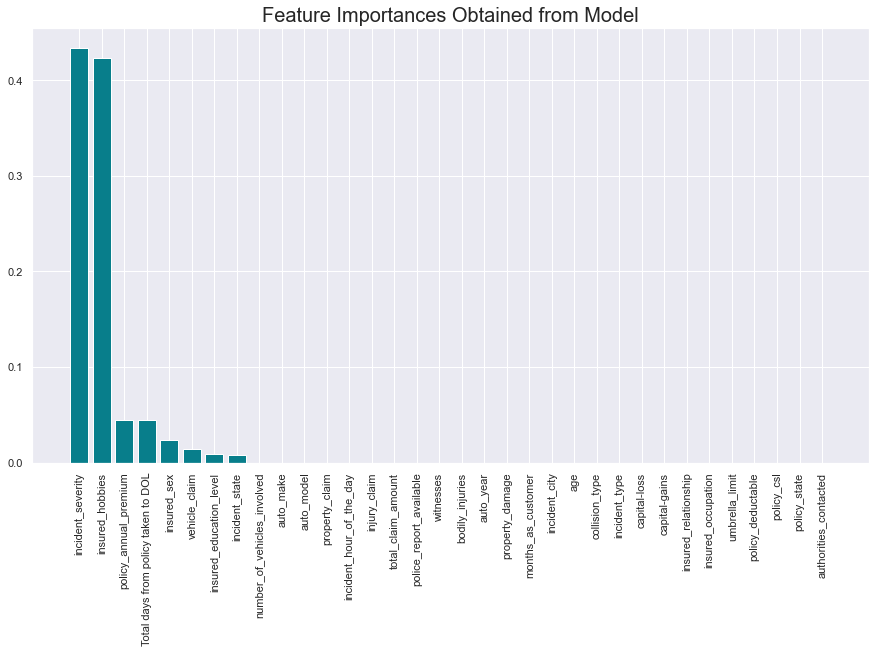

In [384]:
feature_importance(clf_DT)

## Feature Importance for XGBoost

In [385]:
clf_XGB = XGBClassifier(validate_parameters=True, eval_metric='auc',
                    learning_rate=0.01, max_depth=5, scale_pos_weight = 5, silent=True, verbosity=0)
clf_XGB.fit(x_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=5, silent=True, subsample=1, tree_method='exact',
              validate_parameters=True, verbosity=0)

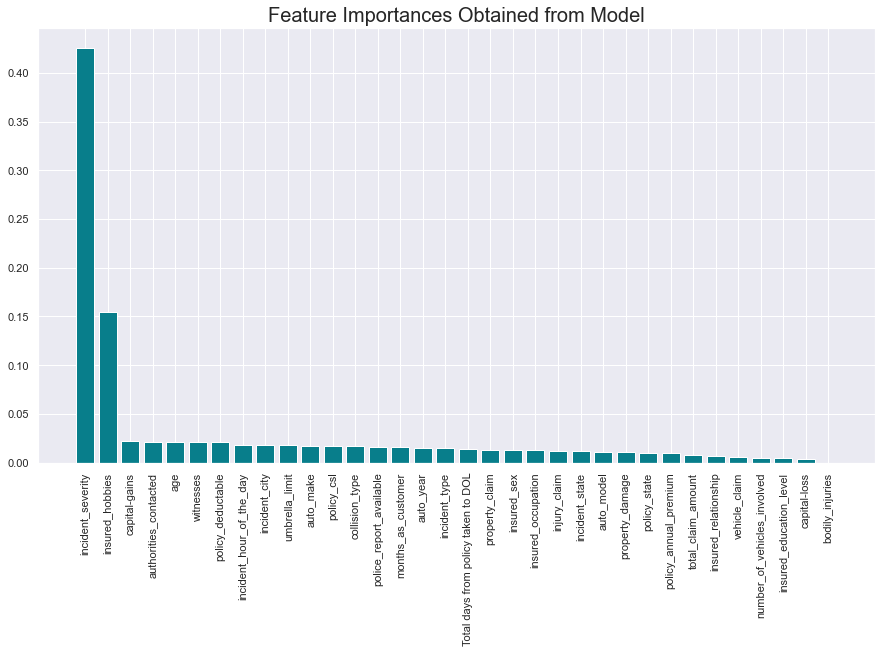

In [386]:
feature_importance(clf_XGB)

In [379]:
clf_XGB.feature_importances_

array([0.01551071, 0.02077732, 0.00997908, 0.01693675, 0.02062759,
       0.00942386, 0.01754601, 0.01313988, 0.00425563, 0.01305396,
       0.1544731 , 0.00671591, 0.02239732, 0.00347968, 0.01449861,
       0.01693391, 0.42506984, 0.02085737, 0.01152129, 0.01755071,
       0.01798718, 0.00457352, 0.01077074, 0.        , 0.02077357,
       0.01639931, 0.00812556, 0.0115277 , 0.01325426, 0.00538664,
       0.01695759, 0.01079686, 0.01455993, 0.01413852], dtype=float32)